In [28]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import random

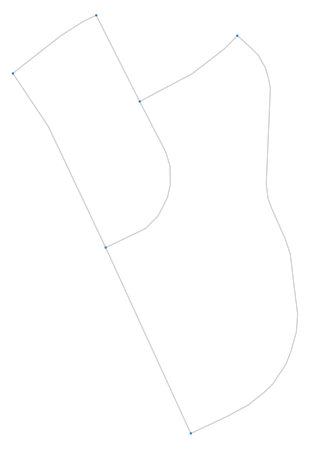

In [29]:

#Creating a bounding box
east, north, west, south = -78.814231,35.566406,-78.810755,35.570595
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)


lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [30]:
pathlist

[1278913066.0,
 1278913077,
 1278913077.0,
 1278913206,
 1278913206.0,
 1278912898,
 1278912898.0,
 1278913064,
 1278913064.0,
 1278913223,
 1278913223.0,
 1278913066]

In [31]:
routes

[[(2, 3), (3, 4), (4, 0), (0, 1), (1, 5), (5, 2)]]

In [32]:
data4

,Nodes,Latitude,Longitude
0,1.278913e+09,35.568139,-78.813101
1,1.278913e+09,35.569701,-78.814124
2,1.278913e+09,35.569701,-78.814124
3,1.278913e+09,35.570223,-78.813205
4,1.278913e+09,35.570223,-78.813205
5,1.278913e+09,35.569449,-78.812725
6,1.278913e+09,35.569449,-78.812725
7,1.278913e+09,35.570040,-78.811649
8,1.278913e+09,35.570040,-78.811649
9,1.278913e+09,35.566471,-78.812162


In [33]:
lat2

[35.568139,
 35.5682083,
 35.569225,
 35.5696339,
 35.5697011,
 35.5697011,
 35.5697471,
 35.5698197,
 35.5700451,
 35.5701717,
 35.5701871,
 35.5702227,
 35.5702227,
 35.570155,
 35.5694491,
 35.5694491,
 35.5694787,
 35.5697,
 35.569923,
 35.5699905,
 35.57004,
 35.57004,
 35.569975,
 35.5699388,
 35.5698645,
 35.5697497,
 35.569653,
 35.5695668,
 35.5687103,
 35.5685803,
 35.5684931,
 35.5682114,
 35.568081,
 35.5677659,
 35.567541,
 35.5673849,
 35.5672076,
 35.567095,
 35.5669112,
 35.5668394,
 35.5667274,
 35.5666292,
 35.5665036,
 35.5664715,
 35.5664715,
 35.5665398,
 35.5680563,
 35.568139]

In [34]:
long2

[-78.813101,
 -78.8131413,
 -78.813733,
 -78.8140689,
 -78.8141241,
 -78.8141241,
 -78.8140532,
 -78.8139415,
 -78.8135851,
 -78.8133389,
 -78.8132983,
 -78.8132046,
 -78.8132046,
 -78.8131627,
 -78.8127255,
 -78.8127255,
 -78.8126568,
 -78.812144,
 -78.81179,
 -78.8117086,
 -78.811649,
 -78.811649,
 -78.8115591,
 -78.8115091,
 -78.8114172,
 -78.8113384,
 -78.811304,
 -78.8112847,
 -78.8113299,
 -78.8113106,
 -78.8112715,
 -78.811118,
 -78.811065,
 -78.8110191,
 -78.8109834,
 -78.8109974,
 -78.8110578,
 -78.811111,
 -78.8112608,
 -78.811355,
 -78.8115268,
 -78.8117489,
 -78.8120781,
 -78.8121623,
 -78.8121623,
 -78.8122008,
 -78.8130545,
 -78.813101]

In [35]:
newdf = pd.DataFrame()
newdf['Latitude'] = lat2
newdf['Longitude'] = long2

In [36]:
newdf

,Latitude,Longitude
0,35.568139,-78.813101
1,35.568208,-78.813141
2,35.569225,-78.813733
3,35.569634,-78.814069
4,35.569701,-78.814124
5,35.569701,-78.814124
6,35.569747,-78.814053
7,35.569820,-78.813941
8,35.570045,-78.813585
9,35.570172,-78.813339


In [37]:
random.randint(1,10)

8

In [42]:
random.randint(35,64)

60

In [58]:
Trash = []
for i in newdf.index:
    Trash.append(random.randint(10,25))

In [59]:
len(Trash)

48

In [60]:
newdf['Trash'] = Trash

In [61]:
newdf

,Latitude,Longitude,Trash
0,35.568139,-78.813101,12
1,35.568208,-78.813141,23
2,35.569225,-78.813733,14
3,35.569634,-78.814069,23
4,35.569701,-78.814124,25
5,35.569701,-78.814124,11
6,35.569747,-78.814053,24
7,35.569820,-78.813941,23
8,35.570045,-78.813585,20
9,35.570172,-78.813339,13


In [62]:
sum(Trash)

817

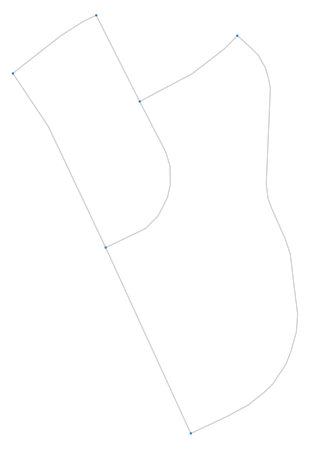

In [63]:

#Creating a bounding box
east, north, west, south = -78.814231,35.566406,-78.810755,35.570595
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)


lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
        
newdf = pd.DataFrame()
newdf['Latitude'] = lat2
newdf['Longitude'] = long2
Trash = []
for i in newdf.index:
    Trash.append(random.randint(10,25))
newdf['Trash'] = Trash
            
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [64]:
sum(Trash)

830

In [65]:
#Time SPent: 100 - 600 seconds
#Collection Point Type: Freestanding Container, Covered and Open, Covered and Closed
#Building Type: Single Family Housing, Multi Family Housing, Work Places
#Surface Type: Paved, Unpaved
#Number of Loaders: 1, 2
#Planned Cleaning: No cleaning, Bin Cleaning
#Truck Distance from Collection Point: 0-15 m, 15-30 m, >30m

In [71]:
random.choice(['Single Family Housing', 'Multi Family Housing', 'Work Places'])

'Single Family Housing'

In [79]:
Time_Spent = []
Collection_Point_Type = []
Building_Type = []
Surface_Type = []
Number_of_Loaders = []
Planned_Cleaning = []
Truck_Distance = []
for i in newdf.index:
    Trash.append(random.randint(10,25))
    Time_Spent.append(random.choice(['<300','>300']))
    Collection_Point_Type.append(random.choice(['Freestanding Container', 'Covered and Open', 'Covered and Closed']))
    Building_Type.append(random.choice(['Single Family Housing', 'Multi Family Housing', 'Work Places']))
    Surface_Type.append(random.choice(['Paved', 'Unpaved']))
    Number_of_Loaders.append(random.choice(['1', '2']))
    Planned_Cleaning.append(random.choice(['No Cleaning', 'Bin Cleaning']))
    Truck_Distance.append(random.choice(['0-15 m', '15-30 m', '>30m']))


In [80]:
newdf['Time_Spent'] = Time_Spent
newdf['Collection_Point_Type'] = Collection_Point_Type
newdf['Building_Type'] = Building_Type
newdf['Surface_Type'] = Surface_Type
newdf['Number_of_Loaders'] = Number_of_Loaders
newdf['Planned_Cleaning'] = Planned_Cleaning
newdf['Truck_Distance'] = Truck_Distance

In [81]:
newdf

,Latitude,Longitude,Trash,Time_Spent,Collection_Point_Type,Building_Type,Surface_Type,Number_of_Loaders,Planned_Cleaning,Truck_Distance
0,35.568139,-78.813101,15,<300,Freestanding Container,Single Family Housing,Unpaved,2,No Cleaning,15-30 m
1,35.568208,-78.813141,20,<300,Freestanding Container,Work Places,Unpaved,2,No Cleaning,0-15 m
2,35.569225,-78.813733,24,<300,Covered and Closed,Single Family Housing,Unpaved,1,No Cleaning,0-15 m
3,35.569634,-78.814069,22,<300,Covered and Open,Multi Family Housing,Paved,1,No Cleaning,0-15 m
4,35.569701,-78.814124,23,<300,Covered and Closed,Work Places,Unpaved,2,Bin Cleaning,>30m
5,35.569701,-78.814124,21,<300,Covered and Open,Single Family Housing,Paved,1,Bin Cleaning,0-15 m
6,35.569747,-78.814053,21,<300,Freestanding Container,Multi Family Housing,Paved,1,No Cleaning,15-30 m
7,35.569820,-78.813941,12,<300,Covered and Open,Single Family Housing,Paved,2,Bin Cleaning,>30m
8,35.570045,-78.813585,24,>300,Covered and Closed,Multi Family Housing,Paved,1,No Cleaning,>30m
9,35.570172,-78.813339,24,>300,Freestanding Container,Work Places,Unpaved,2,No Cleaning,15-30 m


In [82]:
dummy1 = pd.get_dummies(newdf)

In [85]:
dummy1 = dummy1.drop(['Latitude','Longitude'],axis=1)

In [87]:
response = dummy1['Time_Spent_>300']

In [91]:
dummy1 = dummy1.drop(['Time_Spent_<300','Time_Spent_>300'],axis=1)

In [93]:
dummy1

,Trash,Collection_Point_Type_Covered and Closed,Collection_Point_Type_Covered and Open,Collection_Point_Type_Freestanding Container,Building_Type_Multi Family Housing,Building_Type_Single Family Housing,Building_Type_Work Places,Surface_Type_Paved,Surface_Type_Unpaved,Number_of_Loaders_1,Number_of_Loaders_2,Planned_Cleaning_Bin Cleaning,Planned_Cleaning_No Cleaning,Truck_Distance_0-15 m,Truck_Distance_15-30 m,Truck_Distance_>30m
0,15,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0
1,20,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0
2,24,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0
3,22,0,1,0,1,0,0,1,0,1,0,0,1,1,0,0
4,23,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1
5,21,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0
6,21,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0
7,12,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1
8,24,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1
9,24,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0


In [96]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(dummy1, response)

LinearRegression()

In [119]:
#print(regr.coef_)

In [99]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dummy1, response, test_size = 0.2, random_state = 42)

In [101]:
LR = linear_model.LinearRegression()
LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)

In [116]:
y_prediction1 = []
for i in y_prediction:
    y_prediction1.append(int(i))

In [118]:
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_squared_error
#score=r2_score(y_test,y_prediction1)
#print('r2 score is',score)
#print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction1))
#print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction1)))